# Calculate soil properties
Loops over soilgrids data and calculates porosity and conducivity.

NOTE: we're running this AFTER we've already subsetted the continental maps to basins. In a better world, we'd do this for the big map and subset later but it is what it is.

In [1]:
import numpy as np
import os
import pandas as pd
import rasterio
import sys
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
import python_cs_functions as cs

## Config handling

In [2]:
# Specify where the config file can be found
config_file = '../0_config/config.txt'

# Get the required info from the config file
data_path = cs.read_from_config(config_file,'data_path')

# CAMELS-spat metadata
cs_meta_path = cs.read_from_config(config_file,'cs_basin_path')
cs_meta_name = cs.read_from_config(config_file,'cs_meta_name')
cs_unusable_name = cs.read_from_config(config_file,'cs_unusable_name')

# Basin folder
cs_basin_folder = cs.read_from_config(config_file, 'cs_basin_path')
basins_path = Path(data_path) / cs_basin_folder

## Data loading

In [3]:
# CAMELS-spat metadata file
cs_meta_path = Path(data_path) / cs_meta_path
cs_meta = pd.read_csv(cs_meta_path / cs_meta_name)

# Open list of unusable stations; Enforce reading IDs as string to keep leading 0's
cs_unusable = pd.read_csv(cs_meta_path / cs_unusable_name, dtype={'Station_id': object})

## Processing

In [5]:
# Get the array index from the command-line argument
#if len(sys.argv) != 2:
#    print("Usage: python 3a_derive_soil_properties.py <array_index>")
#    sys.exit(1)
#else:
#    ix = int(sys.argv[1])
ix = 456
row = cs_meta.iloc[ix]

In [6]:
# Get shapefile path to determine download coordinates, and forcing destination path
basin_id, _, _, _, _ = cs.prepare_delineation_outputs(cs_meta, ix, basins_path)
print(f' - Processing {basin_id}')

# Define the soilgrids folders
soil_folder = basins_path / 'basin_data' / basin_id / 'geospatial' / 'soilgrids' / 'raw'
sand_folder = soil_folder / 'sand'
clay_folder = soil_folder / 'clay'

# Define the output folders
porosity_folder = soil_folder / 'porosity'
conductivity_folder = soil_folder / 'conductivity'
porosity_folder.mkdir(parents=True, exist_ok=True)
conductivity_folder.mkdir(parents=True, exist_ok=True)

 - Processing CAN_05KB006


In [7]:
depths = ['0-5cm','5-15cm','15-30cm','30-60cm','60-100cm','100-200cm']
layer = 'mean'

### DEBUG

In [15]:
file = 'https://files.isric.org/soilgrids/latest/data/sand/sand_100-200cm_mean/'
folders = cs.find_folders_on_webpage(file)
urls = cs.find_file_urls_in_webpage_folders(folders)

In [20]:
print(f'Number of sand 100-200 mean tiles: {len(urls)}')

Number of sand 100-200 mean tiles: 12970


In [21]:
file = 'https://files.isric.org/soilgrids/latest/data/clay/clay_100-200cm_mean/'
folders = cs.find_folders_on_webpage(file)
urls = cs.find_file_urls_in_webpage_folders(folders)

In [22]:
print(f'Number of clay 100-200 mean tiles: {len(urls)}')

Number of clay 100-200 mean tiles: 12970


### End DEBUG

In [8]:
for depth in depths:

    # Load the sand and clay geotiffs
    sand_file = sand_folder / f'sand_{depth}_{layer}.tif'
    clay_file = clay_folder / f'clay_{depth}_{layer}.tif'
    with rasterio.open(sand_file) as src:
        sand = np.ma.masked_equal(src.read(), src.nodata) # parts per thousand
    with rasterio.open(clay_file) as src:
        clay = np.ma.masked_equal(src.read(), src.nodata) # parts per thousand
        profile = src.profile
        profile.update(
            dtype=rasterio.float32,
            count=1,
            compress='lzw',
            nodata=src.nodata
        )

    # Convert parts per thousand values to percent
    sand = sand / 10
    clay = clay / 10

    # Porosity
    theta_s = 50.5 -0.142 * sand - 0.037 * clay # mean Theta_s (Table 4, Cosby et al., 1984), [%]
    porosity = theta_s / 100 # Convert to fraction to match CAMELS

    # Conductivity
    log_ks = -0.6 + 0.0126 * sand - 0.0064 * clay # mean log Ks (Table 4, Cosby et al., 1984), [inch hr-1]
    conductivity = 2.54 * np.power(10,log_ks) # Convert to cm hr-1 to match CAMELS; can't use 10**log_ks because that will be applied to both data AND mask value

    # Save the results to new geotiffs
    porosity_file = porosity_folder / f'porosity_{depth}_{layer}.tif'
    conductivity_file = conductivity_folder / f'conductivity_{depth}_{layer}.tif'

    with rasterio.open(porosity_file, 'w', **profile) as dst:
        dst.write(porosity.filled().astype(rasterio.float32))

    with rasterio.open(conductivity_file, 'w', **profile) as dst:
        dst.write(conductivity.filled().astype(rasterio.float32))

ValueError: operands could not be broadcast together with shapes (1,116,106) (1,110,107) 

In [9]:
# Files
porosity_files = [porosity_folder / f'porosity_{depth}_{layer}.tif' for depth in depths]
conductivity_files = [conductivity_folder / f'conductivity_{depth}_{layer}.tif' for depth in depths]

# Load the geotiffs for all depths and stack vertically
porosity_list = []
for porosity_file in porosity_files:
    with rasterio.open(porosity_file) as src:
        porosity_nodata = src.nodata
        porosity_list.append(np.ma.masked_equal(src.read(), porosity_nodata).squeeze())      

porosity_stack = np.ma.stack(porosity_list)
porosity_stack.set_fill_value(porosity_nodata)

conductivity_list = []
for conductivity_file in conductivity_files:
    with rasterio.open(conductivity_file) as src:
        conductivity_nodata = src.nodata
        conductivity_list.append(np.ma.masked_equal(src.read(), conductivity_nodata).squeeze())

conductivity_stack = np.ma.stack(conductivity_list)
conductivity_stack.set_fill_value(conductivity_nodata)

# Calculate the average
porosity_mean = np.ma.mean(porosity_stack, axis=0)
porosity_mean.set_fill_value(porosity_nodata)

conductivity_mean = len(conductivity_stack) / np.ma.sum(1 / conductivity_stack, axis=0) # harmonic mean
conductivity_mean.set_fill_value(porosity_nodata)

# Save the results to new geotiffs
porosity_file = porosity_folder / f'porosity_mean-over-depth_{layer}.tif'
conductivity_file = conductivity_folder / f'conductivity_harmonic-mean-over-depth_{layer}.tif'

with rasterio.open(porosity_file, 'w', **profile) as dst:
    to_file = np.expand_dims(porosity_mean, axis=0)
    dst.write(to_file.filled().astype(rasterio.float32))

with rasterio.open(conductivity_file, 'w', **profile) as dst:
    to_file = np.expand_dims(conductivity_mean, axis=0)
    dst.write(to_file.filled().astype(rasterio.float32))

#### Visual checks

In [14]:
import matplotlib.pyplot as plt

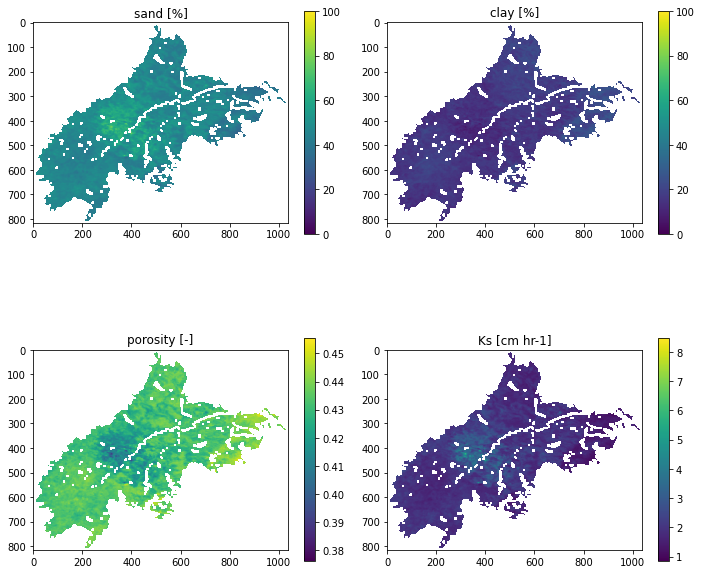

In [34]:
fig,axs = plt.subplots(2,2,figsize=(10,10))

# sand
ax = axs[0,0]
im = ax.imshow(sand[0], cmap='viridis', vmin=0, vmax=100)
fig.colorbar(im, ax=ax, shrink=0.6)
ax.set_title('sand [%]')

# clay
ax = axs[0,1]
im = ax.imshow(clay[0], cmap='viridis', vmin=0, vmax=100)
fig.colorbar(im, ax=ax, shrink=0.6)
ax.set_title('clay [%]')

# poro
ax = axs[1,0]
im = ax.imshow(porosity[0], cmap='viridis')
fig.colorbar(im, ax=ax, shrink=0.6)
ax.set_title('porosity [-]')

# cond
ax = axs[1,1]
im = ax.imshow(conductivity[0], cmap='viridis')
fig.colorbar(im, ax=ax, shrink=0.6)
ax.set_title('Ks [cm hr-1]');

plt.tight_layout()

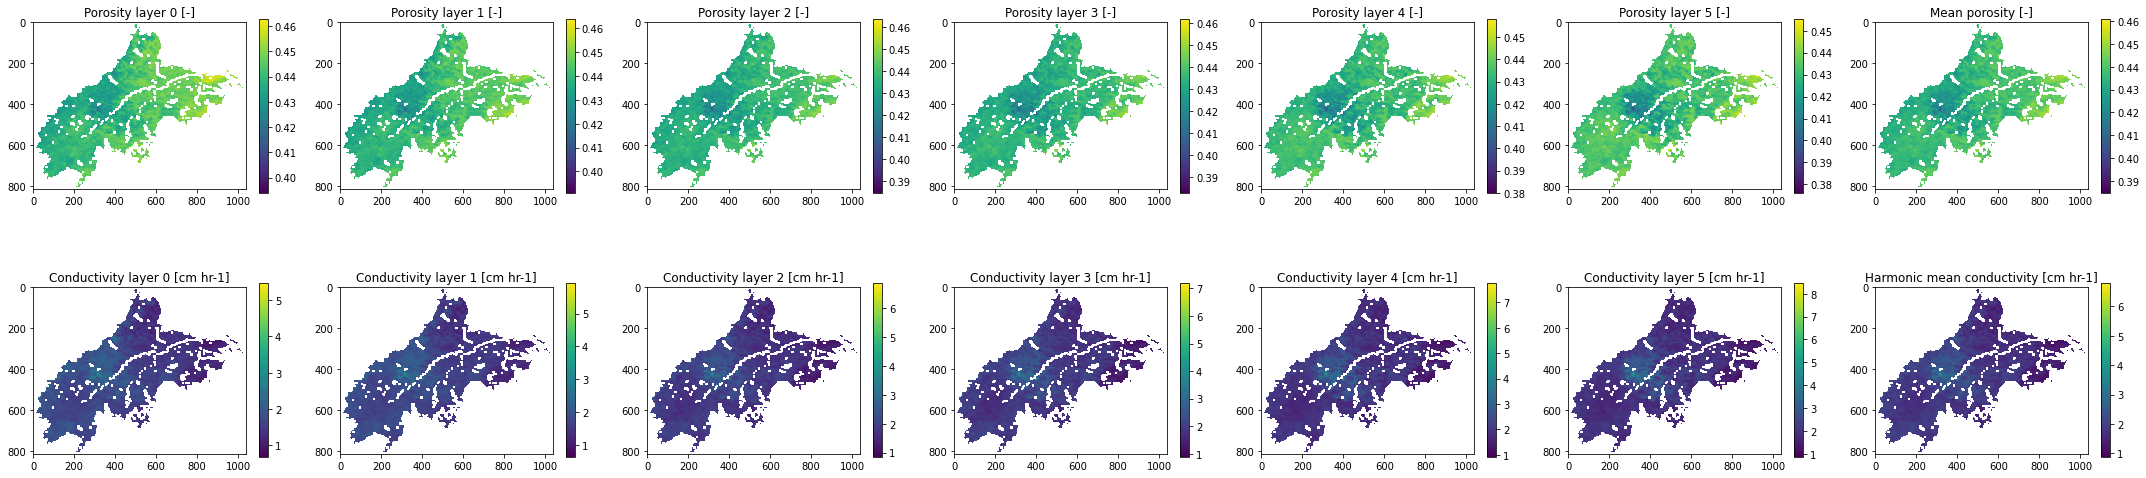

In [138]:
fig,axs = plt.subplots(2,7,figsize=(30,8))

# porosity layers
for layer_id in range(0,6):
    ax = axs[0,layer_id]
    im = ax.imshow(porosity_stack[layer_id], cmap='viridis')
    fig.colorbar(im, ax=ax, shrink=0.6)
    ax.set_title(f'Porosity layer {layer_id} [-]')

ax = axs[0,6]
im = ax.imshow(porosity_mean, cmap='viridis')
fig.colorbar(im, ax=ax, shrink=0.6)
ax.set_title('Mean porosity [-]')

# conductivity layers
for layer_id in range(0,6):
    ax = axs[1,layer_id]
    im = ax.imshow(conductivity_stack[layer_id], cmap='viridis')
    fig.colorbar(im, ax=ax, shrink=0.6)
    ax.set_title(f'Conductivity layer {layer_id} [cm hr-1]')

ax = axs[1,6]
im = ax.imshow(conductivity_mean, cmap='viridis')
fig.colorbar(im, ax=ax, shrink=0.6)
ax.set_title('Harmonic mean conductivity [cm hr-1]')

plt.tight_layout()